# Deep Knowledge Tracing with ModernBERT

This notebook demonstrates our approach to simulating student responses in an educational platform using **Deep Knowledge Tracing (DKT)** with **ModernBERT**. Each student is treated as a unique case, and we fine-tune separate ModernBERT models per student. The key goal is to predict whether a student will answer a given question correctly or incorrectly based on:

- The text of the question and its multiple-choice options.
- The topic, subject, and other relevant attributes.
- The student's past performance (implicitly learned during training).

Our broader objective is to create synthetic "student models" that can help us estimate question difficulty without requiring costly large-scale field testing with real students.

## Notebook Overview
1. **Imports and Environment Setup**: We load environment variables and import the required Python libraries.
2. **Data Loading and Preparation**: We read the main dataset, remove duplicates, and prepare it for training.
3. **User Selection**: We select the top 50 users based on the number of answers submitted.
4. **Model Training Function**: We define a function that fine-tunes a ModernBERT model for a specific user.
5. **Batch Training**: We loop over the selected users and fine-tune a separate model for each.
6. **Next Steps**: Outline potential next steps, such as evaluating performance, computing difficulty metrics, etc.

In [2]:
# 1) Imports and Environment Setup

from dotenv import load_dotenv  # For loading environment variables from a .env file
import os
import pandas as pd
import matplotlib.pyplot as plt

# Load environment variables
load_dotenv()

print("[INFO] Environment variables loaded and libraries imported.")

[INFO] Environment variables loaded and libraries imported.


### Data Loading
In this section, we load the main dataset that contains all the user interactions (student answers to questions). We remove duplicate entries (if any) to ensure that each `answer_id` is unique. This step helps maintain data quality.

In [ ]:
# 2) Data Loading and Preparation

# Load the master dataset that has the translated version of all records
df_original = pd.read_csv('../../data/new/master_translated.csv')
print(f"[INFO] Loaded master dataset with {len(df_original):,} rows.")

# Drop duplicate answer_ids to ensure each answer is only counted once
initial_count = len(df_original)
df_original.drop_duplicates(subset=['answer_id'], inplace=True)
final_count = len(df_original)
print(f"[INFO] Duplicates removed: {initial_count - final_count}")
print(f"[INFO] Dataset now has {final_count:,} rows.")

### User Selection
We next identify the top 50 users based on the number of answers submitted. These top users are chosen for individual model training, which will allow us to capture a variety of response patterns from different individuals.

In [ ]:
# 3) Selecting the top 50 users by answer count

# Count how many answers each user has
user_answer_counts = df_original['user_id'].value_counts()

# Select the top 50
top_50_users = user_answer_counts.head(50)

# (Optional) Reverse the order, so you process from smallest to largest if you prefer
top_50_users = top_50_users.iloc[::-1]

print("[INFO] Top 50 users by number of answers:")
for u_id, count in top_50_users.items():
    print(f"- User {u_id}: {count:,} answers")

In [ ]:
# Save top 50 users to CSV
top_50_users_df = pd.DataFrame({
    'user_id': top_50_users.index,
    'answer_count': top_50_users.values
})
top_50_users_df.to_csv('top_50_users.csv', index=False)
print("[INFO] Saved top 50 users to top_50_users.csv")


### Model Training Setup
Below, we install all necessary libraries and define the function that trains a **ModernBERT** model for a single user. We use Hugging Face Transformers to:

1. **Tokenize** our question text + multiple-choice options.
2. **Fine-tune** a ModernBERT-based binary classifier.
3. **Evaluate** performance (using a weighted F1 score, which is important because the dataset can be imbalanced).

Key libraries and components:
- **Datasets**: For handling train/validation splits in a memory-efficient manner.
- **AutoTokenizer** and **AutoModelForSequenceClassification**: Automatically load the correct tokenizer and model configuration.
- **Trainer** and **TrainingArguments**: Simplify the training loop, logging, checkpointing, and evaluation.

In [ ]:
# 4) Model Definition and Utility Imports

from sklearn.model_selection import train_test_split

from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)
from transformers.trainer_utils import get_last_checkpoint
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

print("[INFO] Transformers and related libraries loaded.")

### Train a Model for One User
The following function, `train_user_model`, encapsulates all the steps for training a ModernBERT model on data from a single user. The pipeline:

1. **Filter** the DataFrame to retrieve only rows belonging to the target user.
2. **Combine** the question text, the multiple-choice options, and meta-info (topic, subject, axis) into one string.
3. **Split** the user's data into train/test sets.
4. **Tokenize** the text for ModernBERT.
5. **Initialize** and **train** the model (using the Hugging Face Trainer).
6. **Evaluate** using a weighted F1 metric.
7. **Save** the best checkpoint.

If `push_to_hub=True`, the final model can be automatically uploaded to the Hugging Face Hub.

In [25]:
def check_model_exists_on_hub(hub_repo_id, hub_token=None):
    """
    Check if a model repository exists on the Hugging Face Hub.
    
    Args:
        hub_repo_id (str): The repository ID on Hugging Face Hub
        hub_token (str, optional): Access token for Hugging Face Hub
    
    Returns:
        bool: True if the repository exists, False otherwise
    """
    import requests
    from requests.exceptions import HTTPError, ConnectionError
    
    headers = {"Authorization": f"Bearer {hub_token}"} if hub_token else None
    
    try:
        # Check if the repository exists by making a HEAD request
        response = requests.head(
            f"https://huggingface.co/api/models/{hub_repo_id}",
            headers=headers,
            timeout=10
        )
        
        # If status code is 200, the repository exists
        return response.status_code == 200
    
    except (HTTPError, ConnectionError, requests.Timeout) as e:
        # Log the error but don't fail the process
        print(f"Error checking if model exists on Hub: {str(e)}")
        return False


def train_user_model(
    df: pd.DataFrame,
    user_id: int,
    model_name: str = "answerdotai/ModernBERT-base",
    output_dir_base: str = "user_models",
    push_to_hub: bool = False,
    hub_repo_org: str = None,
    hub_token: str = None,
    num_train_epochs: int = 10,
    batch_size: int = 4,
    learning_rate: float = 5e-5,
    weight_decay: float = 0.01,
    patience: int = 3,
    max_length: int = 512,
    hub_max_retries: int = 3,
    hub_retry_delay: int = 60
):
    """
    Trains a ModernBERT model to predict which answer option a user will select.

    Args:
        df (pd.DataFrame): The entire dataset containing rows for all users.
        user_id (int): The target user's identifier.
        model_name (str): Hugging Face model ID for ModernBERT.
        output_dir_base (str): Base directory where user-specific checkpoints will be stored.
        push_to_hub (bool): Whether to push the final model to the Hugging Face Hub.
        hub_repo_org (str): Org or username for HF Hub repositories.
        hub_token (str): Personal access token if required for private repos.
        num_train_epochs (int): Maximum number of epochs to train.
        batch_size (int): Training batch size.
        learning_rate (float): Initial learning rate for optimizer.
        weight_decay (float): L2 regularization strength.
        patience (int): Number of epochs to wait for improvement before early stopping.
        max_length (int): Maximum token length for inputs.
        hub_max_retries (int): Number of retries for Hub operations.
        hub_retry_delay (int): Delay in seconds between Hub retries.
    """
    import os
    import numpy as np
    import pandas as pd
    import time
    import requests
    from requests.exceptions import HTTPError, ConnectionError
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
    from transformers import (
        AutoTokenizer, 
        AutoModelForSequenceClassification, 
        TrainingArguments, 
        Trainer,
        EarlyStoppingCallback,
        get_linear_schedule_with_warmup
    )
    from datasets import Dataset, DatasetDict
    import torch
    import matplotlib.pyplot as plt
    import seaborn as sns
    from collections import Counter

    # Create output directory
    user_output_dir = os.path.join(output_dir_base, f"user_{user_id}")
    os.makedirs(user_output_dir, exist_ok=True)
    
    # Set up logging
    import logging
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - [User %(message)s]',
        handlers=[
            logging.FileHandler(os.path.join(user_output_dir, "training.log")),
            logging.StreamHandler()
        ]
    )
    logger = logging.getLogger(__name__)
    
    # 1) Filter user data
    df_user = df[df["user_id"] == user_id].copy()

    # Check if user has any data
    if df_user.empty:
        logger.warning(f"{user_id} No data. Skipping.")
        return None, None

    # Convert selected answer to integer labels (0-4 for A-E)
    option_mapping = {"a": 0, "b": 1, "c": 2, "d": 3, "e": 4}
    df_user["label"] = df_user["student_answer_letter"].str.lower().map(option_mapping)
    
    # Check if any NaN values (in case some options aren't in our mapping)
    if df_user["label"].isna().any():
        logger.warning(f"{user_id} {df_user['label'].isna().sum()} rows have unknown answer options.")
        df_user = df_user.dropna(subset=["label"])
        
    # Convert to integer type
    df_user["label"] = df_user["label"].astype(int)
    
    # Analyze class distribution
    label_counts = Counter(df_user["label"])
    logger.info(f"{user_id} Class distribution: {dict(label_counts)}")
    
    # Check if we have enough samples per class
    min_samples = min(label_counts.values()) if label_counts else 0
    if min_samples < 2:
        logger.warning(f"{user_id} Some classes have fewer than 2 samples. Consider data augmentation.")
    
    # 2) Combine text with template variation to improve robustness
    def combine_text(row):
        q = str(row.get("question_title", "")).strip()
        a = str(row.get("option_a", "")).strip()
        b = str(row.get("option_b", "")).strip()
        c = str(row.get("option_c", "")).strip()
        d = str(row.get("option_d", "")).strip()
        e = str(row.get("option_e", "")).strip()
        topic = str(row.get("topic_name", "")).strip()
        subj = str(row.get("subject_name", "")).strip()
        axis = str(row.get("axis_name", "")).strip()

        return (
            f"Topic: {topic}\n"
            f"Subject: {subj}\n"
            f"Axis: {axis}\n\n"
            f"Question: {q}\n"
            f"A) {a}\n"
            f"B) {b}\n"
            f"C) {c}\n"
            f"D) {d}\n"
            f"E) {e}"
        )

    df_user["text"] = df_user.apply(combine_text, axis=1)

    # 3) Train/Test split only (due to limited data)
    train_df, test_df = train_test_split(
        df_user,
        test_size=0.2,  # 20% for test, 80% for training
        stratify=df_user["label"],  # Ensure balanced classes in splits
        shuffle=True,
        random_state=42
    )

    # Check if split is valid
    if train_df.empty or test_df.empty:
        logger.warning(f"{user_id} Not enough data to split properly. Skipping.")
        return None, None

    logger.info(f"{user_id} Split sizes: Train={len(train_df)}, Test={len(test_df)}")

    # Build Hugging Face Datasets
    train_dataset_hf = Dataset.from_pandas(train_df[["text", "label"]].reset_index(drop=True))
    test_dataset_hf = Dataset.from_pandas(test_df[["text", "label"]].reset_index(drop=True))

    ds_dict = DatasetDict({
        "train": train_dataset_hf,
        "validation": test_dataset_hf,  # Use test set as validation during training
        "test": test_dataset_hf
    })

    # 4) Tokenize
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    def tokenize_fn(batch):
        return tokenizer(
            batch["text"],
            padding="max_length",
            truncation=True,
            max_length=max_length
        )

    ds_dict = ds_dict.map(tokenize_fn, batched=True)

    # 5) Load Model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=5,  # Options A-E
        problem_type="single_label_classification"
    )

    # 6) Training Arguments with improved settings and Hub error handling
    push_to_hub_original = push_to_hub  # Store original setting
    
    # Define a safe hub strategy
    hub_strategy = "every_save" if push_to_hub else "no"
    
    if push_to_hub:
        if hub_repo_org:
            hub_repo_id = f"{hub_repo_org}/modernbert-match-user-{user_id}"
        else:
            hub_repo_id = f"modernbert-match-user-{user_id}"
            
        # Test connectivity to Hugging Face Hub
        try:
            # Simple connectivity test
            response = requests.head("https://huggingface.co/api/models", 
                                    headers={"Authorization": f"Bearer {hub_token}"} if hub_token else None,
                                    timeout=10)
            response.raise_for_status()
        except (HTTPError, ConnectionError, requests.Timeout) as e:
            logger.warning(f"{user_id} Cannot connect to Hugging Face Hub: {str(e)}. Will train locally only.")
            push_to_hub = False
            hub_strategy = "no"
            hub_repo_id = None
    else:
        hub_repo_id = None

    # Calculate steps for learning rate scheduler
    num_train_examples = len(ds_dict["train"])
    steps_per_epoch = (num_train_examples + batch_size - 1) // batch_size
    total_steps = steps_per_epoch * num_train_epochs
    warmup_steps = int(0.1 * total_steps)  # 10% of total steps

    training_args = TrainingArguments(
        output_dir=user_output_dir,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_train_epochs,
        weight_decay=weight_decay,  # Add L2 regularization
        use_mps_device=torch.backends.mps.is_available(),  # Only if available
        bf16=torch.cuda.is_bf16_supported() if torch.cuda.is_available() else False,
        fp16=not torch.cuda.is_bf16_supported() if torch.cuda.is_available() else False,
        optim="adamw_torch_fused" if torch.cuda.is_available() else "adamw_torch",
        logging_dir=os.path.join(user_output_dir, "logs"),
        logging_steps=max(1, steps_per_epoch // 5),  # Log ~5 times per epoch
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",  # Use loss instead of F1 to avoid threshold issues
        greater_is_better=False,  # For loss, lower is better
        save_total_limit=3,
        push_to_hub=push_to_hub,
        hub_model_id=hub_repo_id,
        hub_token=hub_token,
        hub_strategy=hub_strategy,
        report_to="tensorboard",
        lr_scheduler_type="cosine_with_restarts",  # Better than linear
        warmup_steps=warmup_steps,
        # Create private repo
        hub_private_repo=True
    )

    # Define comprehensive metrics
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=-1)
        
        # Calculate various metrics
        acc = accuracy_score(labels, preds)
        f1 = f1_score(labels, preds, average="weighted")
        precision = precision_score(labels, preds, average="weighted", zero_division=0)
        recall = recall_score(labels, preds, average="weighted", zero_division=0)
        
        # Also track per-class metrics for debugging
        f1_per_class = f1_score(labels, preds, average=None, zero_division=0)
        
        results = {
            "accuracy": acc,
            "f1": f1,
            "precision": precision,
            "recall": recall,
        }
        
        # Add per-class F1 scores
        for i, score in enumerate(f1_per_class):
            results[f"f1_class_{i}"] = score
            
        return results

    # Custom implementation to find the last checkpoint
    def find_last_checkpoint(checkpoint_dir):
        if not os.path.isdir(checkpoint_dir):
            return None
            
        # Look for checkpoint directories (they contain 'checkpoint-' in the name)
        subdirs = [os.path.join(checkpoint_dir, d) for d in os.listdir(checkpoint_dir)
                  if os.path.isdir(os.path.join(checkpoint_dir, d)) and 'checkpoint-' in d]
        
        if not subdirs:
            return None
            
        # Sort by checkpoint number (extract the number after 'checkpoint-')
        sorted_dirs = sorted(subdirs, 
                            key=lambda x: int(os.path.basename(x).split('-')[-1]) 
                            if os.path.basename(x).split('-')[-1].isdigit() else 0)
        
        # Return the latest checkpoint
        return sorted_dirs[-1] if sorted_dirs else None
    
    # Check if we should resume training
    last_checkpoint = None
    if os.path.isdir(user_output_dir):
        last_checkpoint = find_last_checkpoint(user_output_dir)
    if last_checkpoint is not None:
        logger.info(f"{user_id} Resuming from {last_checkpoint}.")
    else:
        logger.info(f"{user_id} Starting training from scratch.")

    # 7) Create Trainer with callbacks - use test set for validation
    # For limited data, use a more conservative early stopping setup
    callbacks = [
        EarlyStoppingCallback(
            early_stopping_patience=patience,
            early_stopping_threshold=0.02  # More lenient threshold for smaller datasets
        )
    ]

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=ds_dict["train"],
        eval_dataset=ds_dict["validation"],  # This is actually the test set
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=callbacks
    )

    # 8) Train with Hub error handling
    try:
        train_result = trainer.train(resume_from_checkpoint=last_checkpoint)
        trainer.save_model(user_output_dir)
        trainer.save_state()
        
        # Save training metrics
        metrics = train_result.metrics
        trainer.log_metrics("train", metrics)
        trainer.save_metrics("train", metrics)
        
    except Exception as e:
        if "huggingface_hub" in str(e).lower() or "hub" in str(e).lower() or "504" in str(e):
            # Hub-related error occurred
            logger.warning(f"{user_id} Hugging Face Hub error during training: {str(e)}")
            logger.warning(f"{user_id} Switching to local-only mode and trying again")
            
            # Disable Hub push for this run
            training_args.push_to_hub = False
            training_args.hub_strategy = "no"
            
            # Create a new trainer with updated settings
            # First update the training args
            training_args.push_to_hub = False
            training_args.hub_strategy = "no"
            training_args.hub_model_id = None
            
            # Recreate trainer with updated args
            trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=ds_dict["train"],
                eval_dataset=ds_dict["validation"],
                tokenizer=tokenizer,
                compute_metrics=compute_metrics,
                callbacks=callbacks
            )
            
            # Try training again
            train_result = trainer.train(resume_from_checkpoint=last_checkpoint)
            trainer.save_model(user_output_dir)
            trainer.save_state()
            
            # Save training metrics
            metrics = train_result.metrics
            trainer.log_metrics("train", metrics)
            trainer.save_metrics("train", metrics)
            
            logger.info(f"{user_id} Successfully completed training in local-only mode")
        else:
            # Non-Hub related error, re-raise it
            raise

    # 9) Log final metrics (test set was already used for validation)
    # For consistency, we'll call it "test" in the logs
    test_metrics = trainer.evaluate(ds_dict["test"], metric_key_prefix="test")
    trainer.log_metrics("test", test_metrics)
    trainer.save_metrics("test", test_metrics)
    
    logger.info(f"{user_id} Note: Test metrics are based on the same data used for early stopping")
    
    # 9) Try to manually push to Hub if originally requested and we switched to local
    if push_to_hub_original and not training_args.push_to_hub:
        if hub_token and hub_repo_id:
            try:
                from huggingface_hub import HfApi
                
                logger.info(f"{user_id} Attempting manual push to Hugging Face Hub")
                
                for retry in range(hub_max_retries):
                    try:
                        api = HfApi(token=hub_token)
                        
                        # Create repo if it doesn't exist (private)
                        api.create_repo(
                            repo_id=hub_repo_id,
                            private=True,
                            exist_ok=True
                        )
                        
                        # Upload model files - try both new and old API methods
                        try:
                            # Newer API method
                            api.upload_folder(
                                folder_path=user_output_dir,
                                repo_id=hub_repo_id,
                                commit_message=f"Upload model for user {user_id}",
                                ignore_patterns=["runs/*", "*.log"],
                            )
                        except TypeError:
                            # Fall back to older API method if parameters aren't supported
                            logger.info(f"{user_id} Falling back to older HF Hub API")
                            api.upload_folder(
                                folder_path=user_output_dir,
                                repo_id=hub_repo_id,
                                commit_message=f"Upload model for user {user_id}"
                            )
                        
                        logger.info(f"{user_id} Successfully pushed model to Hub at {hub_repo_id}")
                        break
                    except Exception as e:
                        if retry < hub_max_retries - 1:
                            logger.warning(f"{user_id} Hub push attempt {retry+1} failed: {str(e)}. Retrying in {hub_retry_delay} seconds...")
                            time.sleep(hub_retry_delay)
                        else:
                            logger.warning(f"{user_id} All Hub push attempts failed. Model is saved locally only.")
                            raise
            except Exception as e:
                logger.warning(f"{user_id} Manual Hub push failed: {str(e)}. Model is saved locally only at {user_output_dir}")
    
    # 10) Create and save confusion matrix
    test_logits = trainer.predict(ds_dict["test"]).predictions
    test_preds = np.argmax(test_logits, axis=-1)
    test_labels = ds_dict["test"]["label"]
    
    cm = confusion_matrix(test_labels, test_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - User {user_id}')
    plt.savefig(os.path.join(user_output_dir, "confusion_matrix.png"))
    
    logger.info(f"{user_id} Training complete. Final test metrics: {test_metrics}")
    
    return model, tokenizer


# Function for batch processing users with HF check
def train_all_user_models(
    df: pd.DataFrame,
    user_list: dict,
    hub_repo_org: str = None,  # Add parameter for hub organization/username
    **kwargs
):
    """
    Train models for multiple users with progress tracking and checking for existing models on Hub
    
    Args:
        df: Full dataframe
        user_list: Dictionary of user_id -> count mappings
        hub_repo_org: Organization or username for Hugging Face Hub
        **kwargs: Parameters to pass to train_user_model
    """
    from tqdm import tqdm
    import time
    import os
    import pandas as pd
    import logging
    
    # Set up logging
    output_dir_base = kwargs.get("output_dir_base", "user_models")
    os.makedirs(output_dir_base, exist_ok=True)
    
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(os.path.join(output_dir_base, "batch_training.log")),
            logging.StreamHandler()
        ]
    )
    logger = logging.getLogger(__name__)
    
    results = {}
    hub_token = kwargs.get("hub_token", None)
    hub_repo_org = hub_repo_org or kwargs.get("hub_repo_org", None)
    
    for user_id, count in tqdm(user_list.items(), desc="Training user models"):
        # Determine repository name based on provided organization or username
        if hub_repo_org:
            hub_repo_id = f"{hub_repo_org}/modernbert-match-user-{user_id}"
        else:
            hub_repo_id = f"modernbert-match-user-{user_id}"
        
        # Check if model already exists on Hugging Face Hub
        if check_model_exists_on_hub(hub_repo_id, hub_token):
            logger.info(f"Model for User {user_id} already exists on Hub at {hub_repo_id}. Skipping.")
            print(f"\n=== Model for User {user_id} already exists on Hub at {hub_repo_id}. Skipping. ===")
            
            # Record in results
            results[user_id] = {
                "success": True,
                "skipped": True,
                "reason": "Model already exists on Hub",
                "duration_minutes": 0
            }
            
            # Continue to next user
            continue
        
        print(f"\n=== Training model for User {user_id} (Answers = {count}) ===")
        logger.info(f"Starting training for User {user_id} (Answers = {count})")
        
        start_time = time.time()
        model, tokenizer = train_user_model(
            df=df,
            user_id=user_id,
            hub_repo_org=hub_repo_org,  # Pass the hub_repo_org parameter
            **kwargs,
            hub_max_retries=3,      # Number of times to retry Hub operations
            hub_retry_delay=90      # Wait 90 seconds between retries
        )
        duration = time.time() - start_time
        
        # Store results
        if model is not None:
            results[user_id] = {
                "success": True,
                "skipped": False,
                "duration_minutes": duration / 60
            }
            logger.info(f"Successfully trained model for User {user_id} in {duration/60:.2f} minutes")
        else:
            results[user_id] = {
                "success": False,
                "skipped": False,
                "duration_minutes": duration / 60
            }
            logger.warning(f"Failed to train model for User {user_id} after {duration/60:.2f} minutes")
        
        # Save overall progress
        pd.DataFrame.from_dict(results, orient="index").to_csv(
            os.path.join(output_dir_base, "training_progress.csv")
        )
    
    return results




### Train Models for the Top 50 Users
Now we iterate over the selected top 50 users and train a separate ModernBERT model for each. This step can be time-consuming depending on your hardware and the amount of data per user.

> **Note**: The loop below is configured with `push_to_hub=True`, so if you set up your Hugging Face credentials and tokens in the environment, the models will be uploaded to your account or organization repository. You can set this to `False` if you only want to train locally.

In [ ]:
# Example usage:
OUTPUT_DIR_BASE = "user_models" 

results = train_all_user_models(
    df=df_original,
    user_list=top_50_users,
    model_name="answerdotai/ModernBERT-base",
    output_dir_base=OUTPUT_DIR_BASE,
    push_to_hub=True,
    hub_repo_org="matiashoyl",  # Add your Hugging Face username here
    hub_token=os.getenv("HUGGINGFACE_ACCESS_TOKEN"),
    num_train_epochs=10,   # Maximum epochs (early stopping will usually trigger before this)
    batch_size=4,          # Smaller batch size for limited data
    learning_rate=2e-5,    # Slightly lower learning rate for better stability
    weight_decay=0.01,     # L2 regularization
    patience=3             # Stop if no improvement for 3 epochs
)

### Selecting the questions

In [37]:
df_original = pd.read_csv('../../data/new/master_translated.csv')
top_50_users = pd.read_csv('top_50_users.csv')


# Get all unique question IDs
all_questions = set(df_original['question_id'].unique())

# Get question IDs answered by top 50 users
questions_by_top_users = set(df_original[df_original['user_id'].isin(top_50_users.keys())]['question_id'].unique())

# Find question IDs not answered by top 50 users
unanswered_questions = all_questions - questions_by_top_users

print(f"Total unique questions: {len(all_questions)}")
print(f"Questions answered by top 50 users: {len(questions_by_top_users)}")
print(f"Questions not answered by top 50 users: {len(unanswered_questions)}")

# Convert to DataFrame for easier handling if needed
df_unanswered = pd.DataFrame(list(unanswered_questions), columns=['question_id'])


Total unique questions: 9769
Questions answered by top 50 users: 0
Questions not answered by top 50 users: 9769



Answer statistics for top 30 most answered questions:
Average answers per question: 93.29
Median answers per question: 76.00
Min answers: 45
Max answers: 366


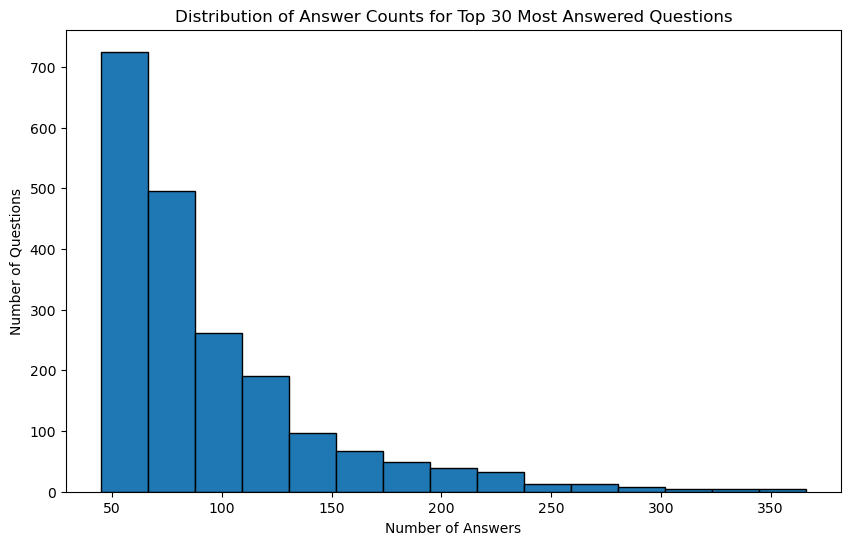

In [38]:
# Get the 2000 questions with the most answers
answer_counts = df_original['question_id'].value_counts()
top_400_questions = answer_counts.head(2000).index

# Get answer statistics for top 30 questions
top_400_answer_counts = answer_counts[top_400_questions]

print(f"\nAnswer statistics for top 30 most answered questions:")
print(f"Average answers per question: {top_400_answer_counts.mean():.2f}")
print(f"Median answers per question: {top_400_answer_counts.median():.2f}")
print(f"Min answers: {top_400_answer_counts.min()}")
print(f"Max answers: {top_400_answer_counts.max()}")

# Show distribution of answer counts
plt.figure(figsize=(10, 6))
plt.hist(top_400_answer_counts, bins=15, edgecolor='black')
plt.title('Distribution of Answer Counts for Top 30 Most Answered Questions')
plt.xlabel('Number of Answers')
plt.ylabel('Number of Questions')
plt.show()


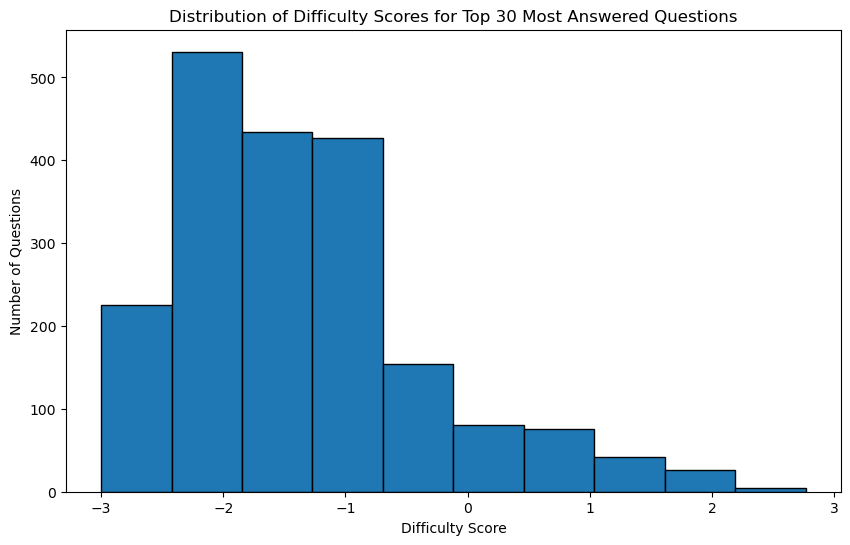


Difficulty statistics for top 30 most answered questions:
Average difficulty: -1.37
Median difficulty: -1.48
Min difficulty: -3.00
Max difficulty: 2.77


In [40]:
# Get difficulty scores for top 30 questions
top_400_difficulties = df_original[df_original['question_id'].isin(top_400_questions)]['difficulty'].unique()

# Create mapping of question_id to difficulty
question_difficulty_map = df_original[['question_id', 'difficulty']].drop_duplicates().set_index('question_id')
top_400_difficulties = question_difficulty_map.loc[top_400_questions]['difficulty']

plt.figure(figsize=(10, 6))
plt.hist(top_400_difficulties, bins=10, edgecolor='black')
plt.title('Distribution of Difficulty Scores for Top 30 Most Answered Questions')
plt.xlabel('Difficulty Score')
plt.ylabel('Number of Questions')
plt.show()

print(f"\nDifficulty statistics for top 30 most answered questions:")
print(f"Average difficulty: {top_400_difficulties.mean():.2f}")
print(f"Median difficulty: {top_400_difficulties.median():.2f}")
print(f"Min difficulty: {top_400_difficulties.min():.2f}")
print(f"Max difficulty: {top_400_difficulties.max():.2f}")


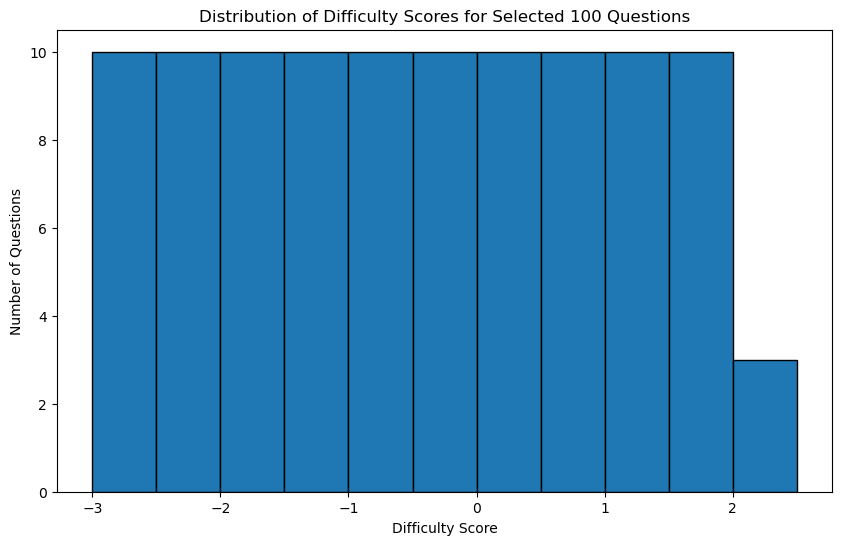


Difficulty statistics for selected 100 questions:
Average difficulty: -0.42
Median difficulty: -0.22
Min difficulty: -3.00
Max difficulty: 2.30


In [41]:
import numpy as np
# Create a dataframe with question_id and difficulty for top 400 questions
question_diff_df = pd.DataFrame({
    'question_id': top_400_questions,
    'difficulty': top_400_difficulties
})

# Create difficulty bins from -3 to 2 in 0.5 increments
bins = np.arange(-3, 3, 0.5)
question_diff_df['diff_bin'] = pd.cut(question_diff_df['difficulty'], bins=bins, labels=False)

# Try to select 10 questions from each bin to get 100 total questions
selected_questions = []
for bin_num in range(len(bins)-1):
    bin_questions = question_diff_df[question_diff_df['diff_bin'] == bin_num]
    if len(bin_questions) > 0:  # Only sample if bin has questions
        selected = bin_questions.sample(min(10, len(bin_questions)))
        selected_questions.append(selected)

final_selection = pd.concat(selected_questions)
selected_100_questions = final_selection['question_id'].values

# Verify distribution of difficulties for selected questions
selected_difficulties = question_difficulty_map.loc[selected_100_questions]['difficulty']

plt.figure(figsize=(10, 6))
plt.hist(selected_difficulties, bins=bins, edgecolor='black')
plt.title('Distribution of Difficulty Scores for Selected 100 Questions')
plt.xlabel('Difficulty Score')
plt.ylabel('Number of Questions')
plt.show()

print(f"\nDifficulty statistics for selected 100 questions:")
print(f"Average difficulty: {selected_difficulties.mean():.2f}")
print(f"Median difficulty: {selected_difficulties.median():.2f}")
print(f"Min difficulty: {selected_difficulties.min():.2f}")
print(f"Max difficulty: {selected_difficulties.max():.2f}")


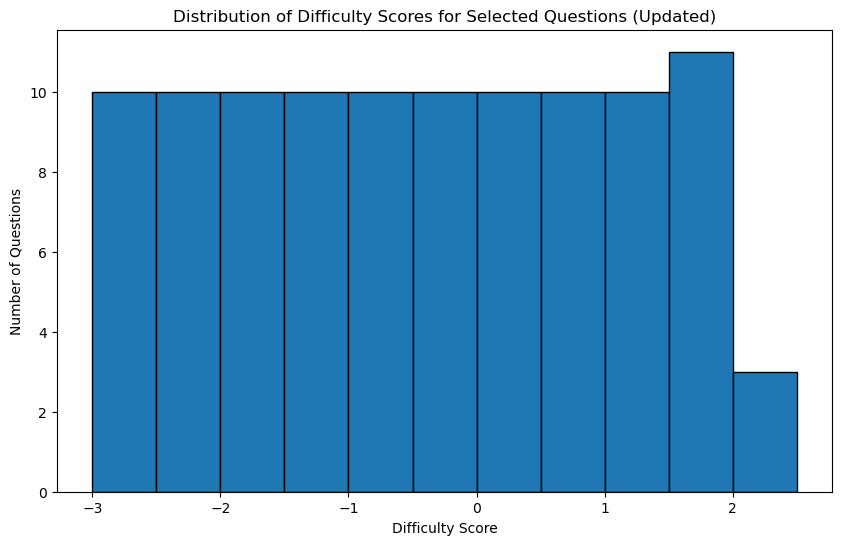


Difficulty statistics for selected questions after adding extreme cases:
Average difficulty: -0.40
Median difficulty: -0.22
Min difficulty: -3.00
Max difficulty: 2.30


In [42]:
# Add one question from -2.5 to -2 bin and one from 1.5 to 2 bin
extreme_bins = [(1.5, 2)]
additional_questions = []

for low, high in extreme_bins:
    # Find questions in this difficulty range from top 400
    bin_questions = question_diff_df[
        (question_diff_df['difficulty'] >= low) & 
        (question_diff_df['difficulty'] < high)
    ]
    if len(bin_questions) > 0:
        selected = bin_questions.sample(1)
        additional_questions.append(selected)

# Add the new questions to our selection
if additional_questions:
    additional_selection = pd.concat(additional_questions)
    selected_100_questions = np.concatenate([
        selected_100_questions,
        additional_selection['question_id'].values
    ])

# Verify updated distribution
selected_difficulties = question_difficulty_map.loc[selected_100_questions]['difficulty']

plt.figure(figsize=(10, 6))
plt.hist(selected_difficulties, bins=bins, edgecolor='black')
plt.title('Distribution of Difficulty Scores for Selected Questions (Updated)')
plt.xlabel('Difficulty Score')
plt.ylabel('Number of Questions')
plt.show()

print(f"\nDifficulty statistics for selected questions after adding extreme cases:")
print(f"Average difficulty: {selected_difficulties.mean():.2f}")
print(f"Median difficulty: {selected_difficulties.median():.2f}")
print(f"Min difficulty: {selected_difficulties.min():.2f}")
print(f"Max difficulty: {selected_difficulties.max():.2f}")

In [43]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269171 entries, 0 to 269170
Data columns (total 34 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   answer_id               269171 non-null  int64  
 1   is_correct              269171 non-null  bool   
 2   created_at              269171 non-null  object 
 3   user_id                 269171 non-null  int64  
 4   grade_id                230853 non-null  float64
 5   grade_name              230853 non-null  object 
 6   school_id               230853 non-null  float64
 7   school_name             230853 non-null  object 
 8   user_level              264075 non-null  float64
 9   question_id             269171 non-null  int64  
 10  options                 269171 non-null  object 
 11  question_title          269171 non-null  object 
 12  correct_option          269171 non-null  object 
 13  solution                269170 non-null  object 
 14  hint                

In [44]:
# Get full question information for selected questions
selected_questions = df_original[df_original['question_id'].isin(selected_100_questions)][
    ['question_id', 'question_title', 'option_a', 'option_b', 'option_c', 'option_d', 'option_e',
     'difficulty', 'topic_name', 'subject_name', 'axis_name', 'correct_option_letter']
]

# Remove duplicate rows based on question_id
selected_questions = selected_questions.drop_duplicates(subset=['question_id'])


print("\nSelected questions information:")
print(f"Total questions: {len(selected_questions)}")
print("\nSample of the selected questions:")
print(selected_questions.head().to_string())

# Save detailed information about distribution across subjects, topics, and axes
print("\nDistribution across subjects:")
print(selected_questions['subject_name'].value_counts())

print("\nDistribution across topics:")
print(selected_questions['topic_name'].value_counts())

print("\nDistribution across axes:")
print(selected_questions['axis_name'].value_counts())




Selected questions information:
Total questions: 104

Sample of the selected questions:
     question_id                                                                                                                                                                                                                                                             question_title            option_a            option_b            option_c            option_d            option_e  difficulty                                         topic_name             subject_name                   axis_name correct_option_letter
45         19708                                                                                                        If two fair dice are thrown, each with 6 faces, and the product of the obtained numbers is 3, what is the probability of having obtained the number 1? <br><br><br>               `1/3`               `1/6`              `2/3 `               `1/2`                   1   -0.

In [45]:
# Save selected questions to CSV for later reference
selected_questions.to_csv('selected_questions.csv', index=False)
print("\nSaved selected questions to 'selected_questions.csv'")



Saved selected questions to 'selected_questions.csv'


### Getting the student responses

In [46]:
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load selected questions from CSV
selected_questions = pd.read_csv('selected_questions.csv')
top_50_users = pd.read_csv('top_50_users.csv')


# ------------------------------------------------------------------
# 1) HELPER FUNCTIONS
# ------------------------------------------------------------------

def create_question_text(row):
    """
    Given a row from df_selected_questions, build the same text format
    used in training (question + choices + topic/subject/axis).
    """
    question_text = str(row.get("question_title", ""))
    a = str(row.get("option_a", ""))
    b = str(row.get("option_b", ""))
    c = str(row.get("option_c", ""))
    d = str(row.get("option_d", ""))
    e = str(row.get("option_e", ""))  # might be empty if only 4 options

    topic = str(row.get("topic_name", ""))
    subject = str(row.get("subject_name", ""))
    axis = str(row.get("axis_name", ""))

    text = (
        f"Topic: {topic}\n"
        f"Subject: {subject}\n"
        f"Axis: {axis}\n\n"
        f"Question: {question_text}\n"
        f"A) {a}\n"
        f"B) {b}\n"
        f"C) {c}\n"
        f"D) {d}\n"
        f"E) {e}"
    )
    return text

def predict_is_correct(model, tokenizer, question_row: dict) -> int:
    """
    Uses a pre-loaded model to predict the label for a question.
    
    Args:
        model: Pre-loaded ModernBERT model
        tokenizer: Pre-loaded tokenizer
        question_row: dict with question data
    Returns:
        int: The predicted label (0-4)
    """
    # 1. Prepare input
    text = create_question_text(question_row)
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    
    # 2. Forward pass -> logits
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    pred = torch.argmax(logits, dim=1).item()
    
    return pred

# ------------------------------------------------------------------
# 2) MAIN LOGIC: BUILD THE (50 × 100) MATRIX
# ------------------------------------------------------------------

def build_predictions_matrix(df_selected_questions, top_50_users):
    """
    For each user in top_50_users, load the HF model, then for each of
    the 30 questions in df_selected_questions, predict the answer label.
    
    Returns:
      - predictions_matrix: numpy array of shape (50, 30),
        where predictions_matrix[i, j] is 0-4 (the predicted label).
      - user_ids_list: list of user IDs in the same order as the matrix rows
      - question_ids: list of question IDs in the same order as the matrix columns
    """
    # Convert top_50_users to a list if it's not already
    if isinstance(top_50_users, pd.Series):
        user_ids_list = top_50_users.index.tolist()
    elif isinstance(top_50_users, pd.DataFrame):
        user_ids_list = top_50_users["user_id"].tolist()
    elif isinstance(top_50_users, (list, np.ndarray)):
        user_ids_list = list(top_50_users)
    else:
        raise ValueError("top_50_users must be list-like or a Series/DataFrame column")

    n_users = len(user_ids_list)
    n_questions = len(df_selected_questions)

    # We'll store the predictions in a 2D numpy array
    predictions_matrix = np.zeros((n_users, n_questions), dtype=int)

    # Get the actual question IDs
    question_ids = df_selected_questions['question_id'].tolist()

    # Loop over each user
    for i, uid in enumerate(user_ids_list):
        model_name_hf = f"matiashoyl/modernbert-match-user-{uid}"
        
        print(f"\n=== Loading model for user {uid}: {model_name_hf} ===")
        # Load model and tokenizer once per user
        tokenizer = AutoTokenizer.from_pretrained(model_name_hf)
        model = AutoModelForSequenceClassification.from_pretrained(model_name_hf)
        model.eval()
        
        # For each question
        for j, q_id in enumerate(question_ids):
            # Get the question row using question_id
            question_dict = df_selected_questions[df_selected_questions['question_id'] == q_id].iloc[0].to_dict()
            pred_label = predict_is_correct(model, tokenizer, question_dict)
            predictions_matrix[i, j] = pred_label
            print(f"[User {uid}] Done predicting question {q_id}")
        
        print(f"[User {uid}] Done predicting on {n_questions} questions.")
        
        # Clean up to free memory
        del model
        del tokenizer
        torch.cuda.empty_cache()  # If using GPU
    
    return predictions_matrix, user_ids_list, question_ids

# ------------------------------------------------------------------
# 3) EXAMPLE USAGE
# ------------------------------------------------------------------

# Build the matrix
pred_matrix, user_ids_list, question_ids = build_predictions_matrix(
    df_selected_questions=selected_questions, 
    top_50_users=top_50_users
)

print("\n== Finished building predictions matrix! ==\n")
print("Matrix shape:", pred_matrix.shape)  # Expect (50, 30)

# Save as numpy array
np.save("predictions_matrix.npy", pred_matrix)

# Create DataFrame with question IDs as columns and save to CSV
df_out = pd.DataFrame(
    data=pred_matrix,
    index=user_ids_list,
    columns=question_ids
)
df_out.to_csv("predictions_matrix.csv")

print("Saved predictions to predictions_matrix.npy and CSV!")



=== Loading model for user 22606: matiashoyl/modernbert-match-user-22606 ===
[User 22606] Done predicting question 19708
[User 22606] Done predicting question 22927
[User 22606] Done predicting question 25111
[User 22606] Done predicting question 26512
[User 22606] Done predicting question 24950
[User 22606] Done predicting question 24939
[User 22606] Done predicting question 20687
[User 22606] Done predicting question 25540
[User 22606] Done predicting question 24095
[User 22606] Done predicting question 24148
[User 22606] Done predicting question 16003
[User 22606] Done predicting question 22936
[User 22606] Done predicting question 25535
[User 22606] Done predicting question 27948
[User 22606] Done predicting question 21353
[User 22606] Done predicting question 17956
[User 22606] Done predicting question 15701
[User 22606] Done predicting question 22210
[User 22606] Done predicting question 23544
[User 22606] Done predicting question 19999
[User 22606] Done predicting question 2070

### Transforming into 0 and 1s matrix

In [50]:
predictions = pd.read_csv("predictions_matrix.csv")
selected_questions = pd.read_csv("selected_questions.csv")

def create_correctness_matrix(predictions_df, selected_questions_df):
    """
    Create a correctness matrix where each cell indicates whether a student's prediction
    for a question is correct (1) or incorrect (0).
    
    Parameters:
    - predictions_df: DataFrame containing predictions where columns are question_ids and 
                     rows are user_ids. Values represent predicted option (0=a, 1=b, etc)
    - selected_questions_df: DataFrame containing question information including correct answers
    
    Returns:
    - correctness_matrix: DataFrame with the same structure as predictions_df but with
                         1 (correct) or 0 (incorrect) values
    """
    # Create a mapping from option letters to prediction values
    letter_to_prediction = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4}
    
    # Create a mapping from question_ids to correct answers (as values, not letters)
    question_to_correct = {}
    for _, row in selected_questions_df.iterrows():
        question_id = str(row['question_id'])
        correct_letter = row['correct_option_letter']
        correct_value = letter_to_prediction[correct_letter]
        question_to_correct[question_id] = correct_value
    
    # Create a copy of the predictions dataframe to store the correctness values
    correctness_matrix = predictions_df.copy()
    
    # Iterate through each question (column) in the predictions matrix
    for question_id in predictions_df.columns:
        # Check if the question_id exists in our mapping
        if str(question_id) in question_to_correct:
            correct_value = question_to_correct[str(question_id)]
            
            # Update the column in the correctness matrix
            # 1 if prediction matches correct answer, 0 otherwise
            correctness_matrix[question_id] = (predictions_df[question_id] == correct_value).astype(int)
    
    return correctness_matrix

# Example usage
correctness_matrix = create_correctness_matrix(predictions, selected_questions)
correctness_matrix.to_csv("correctness_matrix.csv", index=False)

### Computing the IRT parameters

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler

def compute_irt_parameters(correctness_matrix):
    """
    Compute IRT parameters (student ability and question difficulty) using
    maximum likelihood estimation with a 1-parameter IRT model (Rasch model).
    
    Parameters:
    - correctness_matrix: DataFrame where each cell indicates whether a student's prediction 
                         for a question is correct (1) or incorrect (0)
    
    Returns:
    - student_abilities: Series of student abilities indexed by user_id
    - question_difficulties: Series of question difficulties indexed by question_id
    """
    # Filter out any 'Unnamed' columns that might be from CSV imports
    data_columns = [col for col in correctness_matrix.columns if not str(col).startswith('Unnamed')]
    filtered_matrix = correctness_matrix[data_columns]
    
    # Filter out questions that have all 0s or all 1s
    question_means = filtered_matrix.mean(axis=0)
    valid_questions = question_means[(question_means > 0) & (question_means < 1)]
    
    # Print information about filtered questions
    filtered_out = set(filtered_matrix.columns) - set(valid_questions.index)
    if filtered_out:
        print(f"Filtered out {len(filtered_out)} questions with all 0s or all 1s: {list(filtered_out)}")
    
    # Use only valid questions
    filtered_matrix = filtered_matrix[valid_questions.index]
    
    # Make sure we're working with the actual data matrix
    response_matrix = filtered_matrix.values  # NumPy array with just the data
    user_ids = filtered_matrix.index
    question_ids = filtered_matrix.columns
    
    n_users = len(user_ids)
    n_questions = len(question_ids)
    
    # Initial parameter values (set mean ability to 0 for identifiability)
    initial_params = np.zeros(n_users + n_questions)
    
    # Define the negative log-likelihood function
    def neg_log_likelihood(params):
        abilities = params[:n_users]
        difficulties = params[n_users:]
        
        # Center abilities to ensure identifiability
        abilities = abilities - np.mean(abilities)
        
        # Calculate probabilities of correct responses using the IRT model
        logits = np.outer(abilities, np.ones(n_questions)) - np.outer(np.ones(n_users), difficulties)
        probabilities = 1 / (1 + np.exp(-logits))
        
        # Clip probabilities to avoid numerical issues
        probabilities = np.clip(probabilities, 1e-10, 1 - 1e-10)
        
        # Calculate log-likelihood
        ll = np.sum(response_matrix * np.log(probabilities) + 
                   (1 - response_matrix) * np.log(1 - probabilities))
        
        # Add regularization to prevent extreme values
        reg = 0.01 * (np.sum(abilities**2) + np.sum(difficulties**2))
        
        return -ll + reg  # Return negative log-likelihood for minimization
    
    # Optimize parameters
    result = minimize(neg_log_likelihood, initial_params, method='BFGS', 
                      options={'maxiter': 200})
    optimized_params = result.x
    
    # Extract optimized parameters
    abilities = optimized_params[:n_users]
    abilities = abilities - np.mean(abilities)  # Center abilities
    difficulties = optimized_params[n_users:]
    
    # Convert to pandas Series with explicit indices
    student_abilities = pd.Series(abilities, index=user_ids, name='ability')
    question_difficulties = pd.Series(difficulties, index=question_ids, name='difficulty')
    
    return student_abilities, question_difficulties

# Alternative approach using matrix factorization
def compute_irt_params_matrix_factorization(correctness_matrix):
    """
    Approximate IRT parameters using matrix factorization.
    This is faster but less accurate than full MLE estimation.
    """
    from sklearn.decomposition import TruncatedSVD
    
    # Filter out any 'Unnamed' columns that might be from CSV imports
    data_columns = [col for col in correctness_matrix.columns if not str(col).startswith('Unnamed')]
    filtered_matrix = correctness_matrix[data_columns]
    
    # Filter out questions that have all 0s or all 1s
    question_means = filtered_matrix.mean(axis=0)
    valid_questions = question_means[(question_means > 0) & (question_means < 1)]
    
    # Print information about filtered questions
    filtered_out = set(filtered_matrix.columns) - set(valid_questions.index)
    if filtered_out:
        print(f"Filtered out {len(filtered_out)} questions with all 0s or all 1s: {list(filtered_out)}")
    
    # Use only valid questions
    filtered_matrix = filtered_matrix[valid_questions.index]
    
    # Mean-center the matrix by question
    question_means = filtered_matrix.mean(axis=0)
    centered_matrix = filtered_matrix.subtract(question_means)
    
    # Perform SVD to get a 1-dimensional representation
    svd = TruncatedSVD(n_components=1, random_state=42)
    student_abilities_matrix = svd.fit_transform(centered_matrix)
    
    # Extract student abilities and scale them
    scaler = StandardScaler()
    student_abilities = pd.Series(
        scaler.fit_transform(student_abilities_matrix).flatten(), 
        index=filtered_matrix.index, 
        name='ability'
    )
    
    # Extract question parameters (difficulty is negative of the loading)
    question_loadings = svd.components_[0]
    question_difficulties = pd.Series(
        -question_loadings,  # Invert sign so higher values = more difficult
        index=filtered_matrix.columns, 
        name='difficulty'
    )
    
    # Adjust for mean difficulty
    question_difficulties = question_difficulties - question_difficulties.mean() + 0.5 * question_means
    
    return student_abilities, question_difficulties

# When saving to CSV, make sure to use index=True
def save_results(student_abilities, question_difficulties, student_file="student_abilities.csv", question_file="question_difficulties.csv"):
    """
    Save the computed IRT parameters to CSV files, ensuring proper handling of indices.
    """
    # Save student abilities
    student_abilities.to_csv(student_file, header=True)
    
    # Save question difficulties
    question_difficulties.to_csv(question_file, header=True)
    
    print(f"Student abilities saved to {student_file}")
    print(f"Question difficulties saved to {question_file}")

# Example usage with properly filtering unnamed columns
def analyze_irt_results(correctness_matrix, selected_questions=None):
    """
    Compute IRT parameters and print summary statistics.
    """
    print("Computing IRT parameters...")
    
    # First check and remove any unnamed columns
    data_columns = [col for col in correctness_matrix.columns if not str(col).startswith('Unnamed')]
    if len(data_columns) < len(correctness_matrix.columns):
        print(f"Filtered out {len(correctness_matrix.columns) - len(data_columns)} unnamed columns")
        correctness_matrix = correctness_matrix[data_columns]
    
    try:
        # Try the MLE method first (more accurate but slower)
        student_abilities, question_difficulties = compute_irt_parameters(correctness_matrix)
        method = "Maximum Likelihood Estimation"
    except Exception as e:
        print(f"MLE optimization failed: {str(e)}")
        print("Using matrix factorization approach instead...")
        student_abilities, question_difficulties = compute_irt_params_matrix_factorization(correctness_matrix)
        method = "Matrix Factorization"
    
    print(f"\nIRT Analysis Results (using {method}):")
    
    print("\nStudent Ability Statistics:")
    print(student_abilities.describe())
    
    print("\nQuestion Difficulty Statistics:")
    print(question_difficulties.describe())
    
    # Map question IDs to titles if available
    if selected_questions is not None and 'question_id' in selected_questions.columns:
        id_to_title = dict(zip(selected_questions['question_id'].astype(str), 
                              selected_questions['question_title']))
        
        print("\nTop 5 Most Difficult Questions:")
        hardest = question_difficulties.sort_values(ascending=False).head(5)
        for q_id, diff in hardest.items():
            title = id_to_title.get(str(q_id), "Unknown")
            correct_percentage = correctness_matrix[q_id].mean() * 100
            print(f"ID: {q_id}, Difficulty: {diff:.3f}, Correct: {correct_percentage:.1f}%, Title: {title[:50]}...")
        
        print("\nTop 5 Easiest Questions:")
        easiest = question_difficulties.sort_values().head(5)
        for q_id, diff in easiest.items():
            title = id_to_title.get(str(q_id), "Unknown")
            correct_percentage = correctness_matrix[q_id].mean() * 100
            print(f"ID: {q_id}, Difficulty: {diff:.3f}, Correct: {correct_percentage:.1f}%, Title: {title[:50]}...")
    
    return student_abilities, question_difficulties

# Full example of usage
def complete_irt_analysis(predictions_df, selected_questions_df):
    """
    Perform the complete IRT analysis workflow:
    1. Create the correctness matrix
    2. Compute IRT parameters
    3. Save and analyze results
    """
    # Step 1: First make sure we're only using valid columns in predictions
    data_columns = [col for col in predictions_df.columns if not str(col).startswith('Unnamed')]
    clean_predictions = predictions_df[data_columns]
    
    # Step 2: Create the correctness matrix
    print("Creating correctness matrix...")
    letter_to_prediction = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4}
    
    # Create a mapping from question_ids to correct answers (as values, not letters)
    question_to_correct = {}
    for _, row in selected_questions_df.iterrows():
        question_id = str(row['question_id'])
        correct_letter = row['correct_option_letter']
        correct_value = letter_to_prediction[correct_letter]
        question_to_correct[question_id] = correct_value
    
    # Create the correctness matrix
    correctness_matrix = clean_predictions.copy()
    
    # Iterate through each question (column) in the predictions matrix
    for question_id in clean_predictions.columns:
        # Check if the question_id exists in our mapping
        if str(question_id) in question_to_correct:
            correct_value = question_to_correct[str(question_id)]
            
            # Update the column in the correctness matrix
            # 1 if prediction matches correct answer, 0 otherwise
            correctness_matrix[question_id] = (clean_predictions[question_id] == correct_value).astype(int)
    
    # Step 3: Compute IRT parameters
    student_abilities, question_difficulties = analyze_irt_results(correctness_matrix, selected_questions_df)
    
    # Step 4: Save results
    save_results(student_abilities, question_difficulties)
    
    return student_abilities, question_difficulties, correctness_matrix

# Example usage
correctness_matrix = pd.read_csv("correctness_matrix.csv")
selected_questions = pd.read_csv("selected_questions.csv")
student_abilities, question_difficulties = analyze_irt_results(correctness_matrix, selected_questions)

# Optional: Save results to CSV
student_abilities.to_csv("student_abilities.csv")
question_difficulties.to_csv("question_difficulties.csv")

Computing IRT parameters...
Filtered out 1 unnamed columns
Filtered out 6 questions with all 0s or all 1s: ['18315', '27735', '21699', '22110', '16475', '19669']

IRT Analysis Results (using Maximum Likelihood Estimation):

Student Ability Statistics:
count    5.000000e+01
mean     3.108624e-17
std      8.640709e-01
min     -2.473033e+00
25%     -5.561861e-01
50%      1.087456e-01
75%      4.670267e-01
max      1.669374e+00
Name: ability, dtype: float64

Question Difficulty Statistics:
count    98.000000
mean     -0.856619
std       2.541794
min      -4.217446
25%      -3.075471
50%      -1.228748
75%       1.262008
max       4.112158
Name: difficulty, dtype: float64

Top 5 Most Difficult Questions:
ID: 23594, Difficulty: 4.112, Correct: 2.0%, Title: What number raised to 3 is 8?  ...
ID: 22936, Difficulty: 3.431, Correct: 4.0%, Title: Lucas was traveling abroad with thirteen cousins. ...
ID: 23157, Difficulty: 3.431, Correct: 4.0%, Title: María had 7074 pesos in her account. If today 

Number of questions compared: 98
Pearson correlation: 0.1952 (p-value: 0.0540)
Spearman rank correlation: 0.1873 (p-value: 0.0648)

Questions with Largest Discrepancies:
ID: 16422
Title: <div>If the base of the power `(1/2)^2` increases ...
Original difficulty: 2.297
IRT difficulty: -3.518
Discrepancy: 5.815
--------------------------------------------------
ID: 15848
Title: What is the fractional representation of the numbe...
Original difficulty: 2.213
IRT difficulty: -3.518
Discrepancy: 5.730
--------------------------------------------------
ID: 23594
Title: What number raised to 3 is 8?  ...
Original difficulty: -1.502
IRT difficulty: 4.112
Discrepancy: 5.614
--------------------------------------------------
ID: 22252
Title: <div>&nbsp;A bee hive doubles every three months. ...
Original difficulty: -1.864
IRT difficulty: 3.431
Discrepancy: 5.296
--------------------------------------------------
ID: 25858
Title: <div>The result of the expression `2\cdot (-3)^{2}...
Original diffi

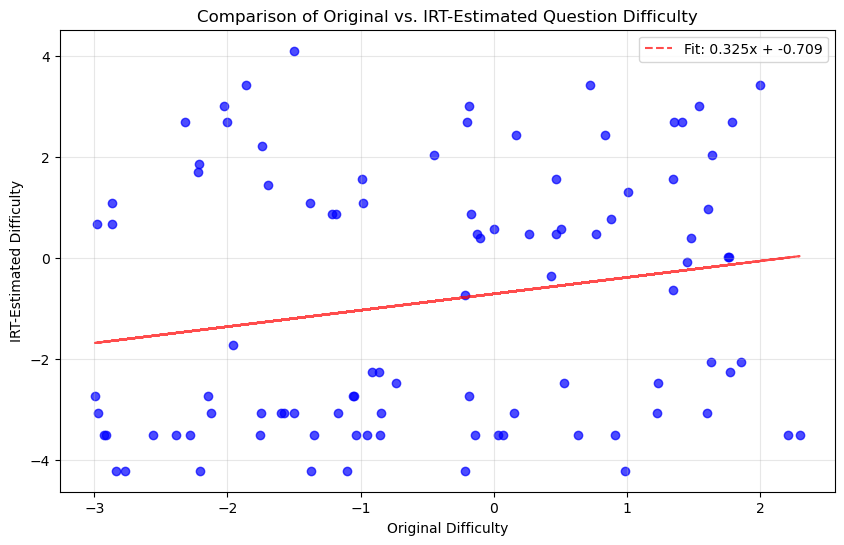

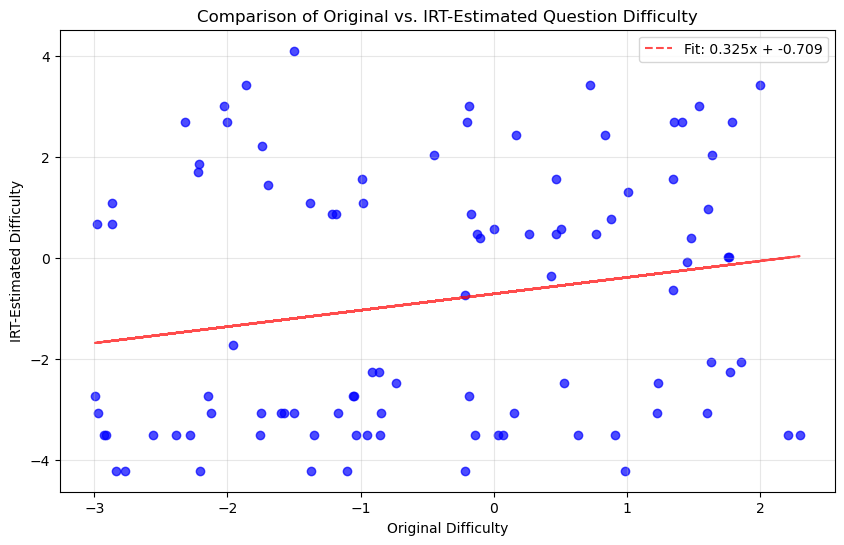

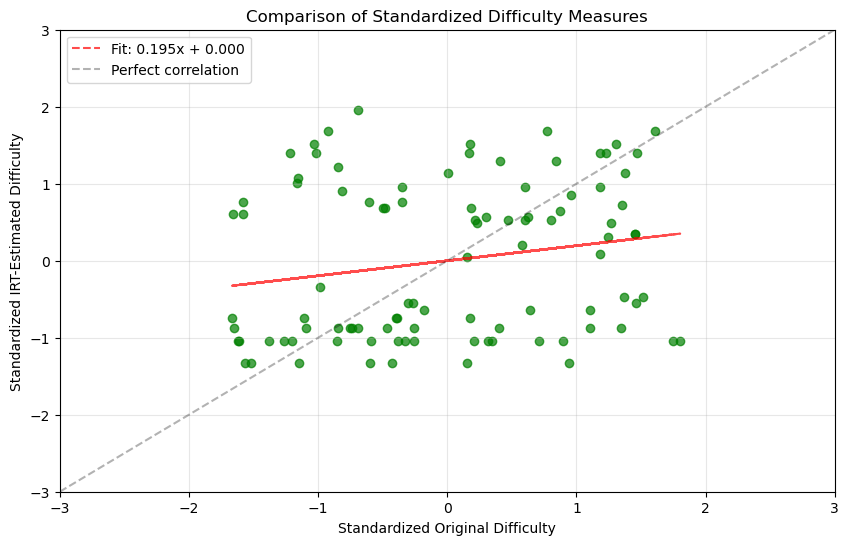

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

def compare_difficulty_values(question_difficulties, selected_questions):
    """
    Compare the IRT-estimated difficulty values with the original difficulty values
    in the selected_questions DataFrame.
    
    Parameters:
    - question_difficulties: Series of IRT-estimated difficulty parameters
    - selected_questions: DataFrame containing original difficulty values
    
    Returns:
    - comparison_df: DataFrame with both difficulty values side by side
    """
    # Ensure question_id is treated as string in both datasets
    selected_questions_copy = selected_questions.copy()
    selected_questions_copy['question_id'] = selected_questions_copy['question_id'].astype(str)
    
    # Create a DataFrame with IRT difficulties
    irt_df = pd.DataFrame({
        'question_id': question_difficulties.index.astype(str),
        'irt_difficulty': question_difficulties.values
    })
    
    # Merge the two DataFrames on question_id
    comparison_df = pd.merge(
        selected_questions_copy[['question_id', 'question_title', 'difficulty']], 
        irt_df,
        on='question_id',
        how='inner'
    ).rename(columns={'difficulty': 'original_difficulty'})
    
    # Calculate correlation between the two difficulty measures
    pearson_corr, pearson_p = pearsonr(comparison_df['original_difficulty'], 
                                       comparison_df['irt_difficulty'])
    spearman_corr, spearman_p = spearmanr(comparison_df['original_difficulty'], 
                                         comparison_df['irt_difficulty'])
    
    print(f"Number of questions compared: {len(comparison_df)}")
    print(f"Pearson correlation: {pearson_corr:.4f} (p-value: {pearson_p:.4f})")
    print(f"Spearman rank correlation: {spearman_corr:.4f} (p-value: {spearman_p:.4f})")
    
    # Create a scatter plot to visualize the relationship
    plt.figure(figsize=(10, 6))
    plt.scatter(comparison_df['original_difficulty'], comparison_df['irt_difficulty'], 
                alpha=0.7, color='blue')
    
    # Add a regression line
    z = np.polyfit(comparison_df['original_difficulty'], comparison_df['irt_difficulty'], 1)
    p = np.poly1d(z)
    plt.plot(comparison_df['original_difficulty'], p(comparison_df['original_difficulty']), 
             "r--", alpha=0.7, label=f"Fit: {z[0]:.3f}x + {z[1]:.3f}")
    
    # Add labels and title
    plt.xlabel('Original Difficulty')
    plt.ylabel('IRT-Estimated Difficulty')
    plt.title('Comparison of Original vs. IRT-Estimated Question Difficulty')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Find questions with the largest discrepancies
    comparison_df['discrepancy'] = abs(comparison_df['original_difficulty'] - 
                                      comparison_df['irt_difficulty'])
    largest_discrepancies = comparison_df.sort_values('discrepancy', ascending=False).head(5)
    
    print("\nQuestions with Largest Discrepancies:")
    for _, row in largest_discrepancies.iterrows():
        print(f"ID: {row['question_id']}")
        print(f"Title: {row['question_title'][:50]}...")
        print(f"Original difficulty: {row['original_difficulty']:.3f}")
        print(f"IRT difficulty: {row['irt_difficulty']:.3f}")
        print(f"Discrepancy: {row['discrepancy']:.3f}")
        print("-" * 50)
    
    # Return the comparison DataFrame
    return comparison_df

def standardize_and_compare(question_difficulties, selected_questions):
    """
    Standardize both difficulty measures and then compare them.
    This is useful since the scales might be different.
    """
    # Create comparison DataFrame
    comparison_df = compare_difficulty_values(question_difficulties, selected_questions)
    
    # Standardize both difficulty measures
    comparison_df['original_difficulty_std'] = (
        comparison_df['original_difficulty'] - comparison_df['original_difficulty'].mean()
    ) / comparison_df['original_difficulty'].std()
    
    comparison_df['irt_difficulty_std'] = (
        comparison_df['irt_difficulty'] - comparison_df['irt_difficulty'].mean()
    ) / comparison_df['irt_difficulty'].std()
    
    # Calculate correlation between standardized measures
    pearson_corr_std, pearson_p_std = pearsonr(comparison_df['original_difficulty_std'], 
                                              comparison_df['irt_difficulty_std'])
    
    print("\nAfter Standardization:")
    print(f"Pearson correlation: {pearson_corr_std:.4f} (p-value: {pearson_p_std:.4f})")
    
    # Create a scatter plot for standardized values
    plt.figure(figsize=(10, 6))
    plt.scatter(comparison_df['original_difficulty_std'], comparison_df['irt_difficulty_std'], 
                alpha=0.7, color='green')
    
    # Add a regression line
    z_std = np.polyfit(comparison_df['original_difficulty_std'], 
                      comparison_df['irt_difficulty_std'], 1)
    p_std = np.poly1d(z_std)
    plt.plot(comparison_df['original_difficulty_std'], 
             p_std(comparison_df['original_difficulty_std']), 
             "r--", alpha=0.7, label=f"Fit: {z_std[0]:.3f}x + {z_std[1]:.3f}")
    
    # Add reference line for perfect correlation
    plt.plot([-3, 3], [-3, 3], 'k--', alpha=0.3, label="Perfect correlation")
    
    # Add labels and title
    plt.xlabel('Standardized Original Difficulty')
    plt.ylabel('Standardized IRT-Estimated Difficulty')
    plt.title('Comparison of Standardized Difficulty Measures')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    
    # Find questions with the largest discrepancies after standardization
    comparison_df['discrepancy_std'] = abs(comparison_df['original_difficulty_std'] - 
                                          comparison_df['irt_difficulty_std'])
    
    print("\nQuestions with Largest Standardized Discrepancies:")
    largest_discrepancies_std = comparison_df.sort_values('discrepancy_std', 
                                                        ascending=False).head(5)
    for _, row in largest_discrepancies_std.iterrows():
        print(f"ID: {row['question_id']}")
        print(f"Title: {row['question_title'][:50]}...")
        print(f"Original difficulty (std): {row['original_difficulty_std']:.3f}")
        print(f"IRT difficulty (std): {row['irt_difficulty_std']:.3f}")
        print(f"Standardized discrepancy: {row['discrepancy_std']:.3f}")
        print("-" * 50)
    
    return comparison_df

# Example usage:
comparison_df = compare_difficulty_values(question_difficulties, selected_questions)
standardized_comparison = standardize_and_compare(question_difficulties, selected_questions)

# To save the comparison results:
comparison_df.to_csv("difficulty_comparison.csv", index=False)

### Subgroup of users

In [10]:
import requests
from bs4 import BeautifulSoup
import re

def extract_metrics_from_url(url):
    """
    Extract metrics from a HuggingFace model page.
    
    Args:
        url: URL of the HuggingFace model page
        
    Returns:
        dict: Dictionary containing the extracted metrics
    """
    # Get user_id from URL
    user_id = url.split("-")[-1]
    
    # Send HTTP request
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Failed to fetch {url}, status code: {response.status_code}")
        return None
    
    # Parse HTML
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Find the model card content div
    model_card = soup.find('div', class_='model-card-content')
    if not model_card:
        print(f"Could not find model card content in {url}")
        return None
    
    # Find the unordered list containing the metrics
    metrics_ul = None
    for ul in model_card.find_all('ul'):
        if ul.find('li') and 'Loss:' in ul.find('li').text:
            metrics_ul = ul
            break
    
    if not metrics_ul:
        print(f"Could not find metrics list in {url}")
        return None
    
    # Extract metrics from list items
    metrics = {
        'user_id': user_id,
        'url': url
    }
    
    metric_patterns = {
        'Loss': r'Loss: ([\d\.]+)',
        'Accuracy': r'Accuracy: ([\d\.]+)',
        'F1': r'F1: ([\d\.]+)',
        'Precision': r'Precision: ([\d\.]+)',
        'Recall': r'Recall: ([\d\.]+)',
        'F1 Class 0': r'F1 Class 0: ([\d\.]+)',
        'F1 Class 1': r'F1 Class 1: ([\d\.]+)',
        'F1 Class 2': r'F1 Class 2: ([\d\.]+)',
        'F1 Class 3': r'F1 Class 3: ([\d\.]+)',
        'F1 Class 4': r'F1 Class 4: ([\d\.]+)'
    }
    
    for li in metrics_ul.find_all('li'):
        text = li.text.strip()
        for metric_name, pattern in metric_patterns.items():
            match = re.search(pattern, text)
            if match:
                metrics[metric_name] = float(match.group(1))
                break
    
    return metrics

# Get top_50_users
top_50_users = pd.read_csv("top_50_users.csv")

results = []
    
for _, user in top_50_users.iterrows():
    url = f"https://huggingface.co/matiashoyl/modernbert-match-user-{user['user_id']}"
    print(f"Processing {url}")
    metrics = extract_metrics_from_url(url)
    if metrics:
        results.append(metrics)

# Convert results to DataFrame
if results:
    df = pd.DataFrame(results)
    
    # Save to CSV
    output_file = "huggingface_model_metrics.csv"
    df.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")
    
    # Display summary
    print(f"Processed {len(results)} out of {len(top_50_users)} models")
    print("Sample of collected data:")
    print(df.head())
else:
    print("No data collected.")

Processing https://huggingface.co/matiashoyl/modernbert-match-user-22606
Could not find metrics list in https://huggingface.co/matiashoyl/modernbert-match-user-22606
Processing https://huggingface.co/matiashoyl/modernbert-match-user-32329
Could not find metrics list in https://huggingface.co/matiashoyl/modernbert-match-user-32329
Processing https://huggingface.co/matiashoyl/modernbert-match-user-22853
Could not find metrics list in https://huggingface.co/matiashoyl/modernbert-match-user-22853
Processing https://huggingface.co/matiashoyl/modernbert-match-user-51978
Could not find metrics list in https://huggingface.co/matiashoyl/modernbert-match-user-51978
Processing https://huggingface.co/matiashoyl/modernbert-match-user-16297
Could not find metrics list in https://huggingface.co/matiashoyl/modernbert-match-user-16297
Processing https://huggingface.co/matiashoyl/modernbert-match-user-52981
Could not find metrics list in https://huggingface.co/matiashoyl/modernbert-match-user-52981
Proc

In [3]:
hf_models = pd.read_csv("huggingface_model_metrics.csv")

Total number of models: 44
Number of models with F1 score > 0.5: 30 (68.18%)
Number of models with F1 score > 0.6: 18 (40.91%)


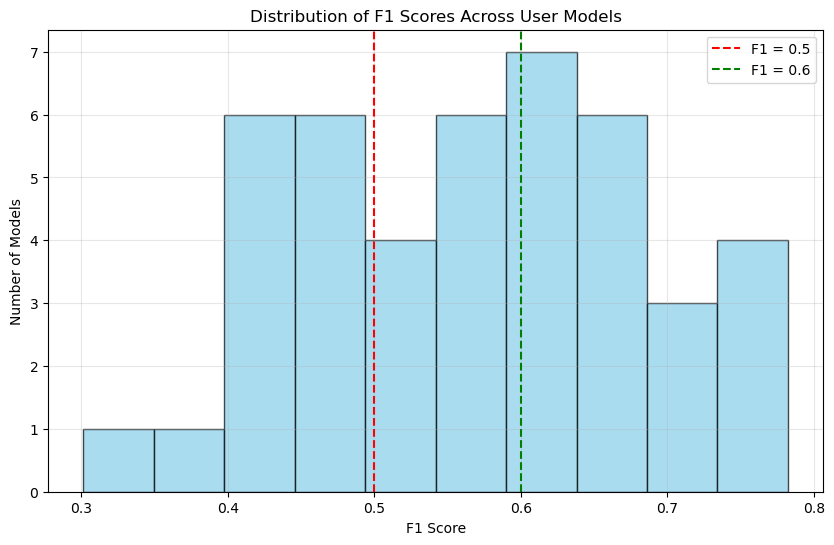

In [4]:
# Analyze F1 scores in the huggingface models
print("Total number of models:", len(hf_models))

# Count models with F1 score over 0.5 (50%)
models_over_50 = hf_models[hf_models['F1'] > 0.5]
print(f"Number of models with F1 score > 0.5: {len(models_over_50)} ({len(models_over_50)/len(hf_models)*100:.2f}%)")

# Count models with F1 score over 0.6 (60%)
models_over_60 = hf_models[hf_models['F1'] > 0.6]
print(f"Number of models with F1 score > 0.6: {len(models_over_60)} ({len(models_over_60)/len(hf_models)*100:.2f}%)")

# Create a histogram of F1 scores
plt.figure(figsize=(10, 6))
plt.hist(hf_models['F1'], bins=10, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=0.5, color='red', linestyle='--', label='F1 = 0.5')
plt.axvline(x=0.6, color='green', linestyle='--', label='F1 = 0.6')
plt.xlabel('F1 Score')
plt.ylabel('Number of Models')
plt.title('Distribution of F1 Scores Across User Models')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [5]:
models_over_50.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, 0 to 43
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   user_id     30 non-null     int64  
 1   url         30 non-null     object 
 2   Loss        30 non-null     float64
 3   Accuracy    30 non-null     float64
 4   F1          30 non-null     float64
 5   Precision   30 non-null     float64
 6   Recall      30 non-null     float64
 7   F1 Class 0  30 non-null     float64
 8   F1 Class 1  30 non-null     float64
 9   F1 Class 2  30 non-null     float64
 10  F1 Class 3  30 non-null     float64
 11  F1 Class 4  30 non-null     float64
dtypes: float64(10), int64(1), object(1)
memory usage: 3.0+ KB


In [6]:
correctness_matrix = pd.read_csv("correctness_matrix.csv")

# Filter the correctness matrix to include only users with F1 score > 0.5
print("Original correctness matrix shape:", correctness_matrix.shape)

# Get the list of user_ids from models with F1 > 0.5
high_performing_users = models_over_50['user_id'].tolist()

# Filter the correctness matrix to include only these users
# First column is user_id, so we need to filter rows based on that
filtered_correctness_matrix = correctness_matrix[correctness_matrix.iloc[:, 0].isin(high_performing_users)]

print("Filtered correctness matrix shape:", filtered_correctness_matrix.shape)
print(f"Retained {len(filtered_correctness_matrix)} out of {len(correctness_matrix)} users ({len(filtered_correctness_matrix)/len(correctness_matrix)*100:.2f}%)")

# Display the first few rows of the filtered matrix
print("\nSample of filtered correctness matrix:")
print(filtered_correctness_matrix.head())

filtered_correctness_matrix.to_csv("filtered_correctness_matrix.csv", index=False)

Original correctness matrix shape: (50, 105)
Filtered correctness matrix shape: (30, 105)
Retained 30 out of 50 users (60.00%)

Sample of filtered correctness matrix:
    Unnamed: 0  19708  22927  25111  26512  24950  24939  20687  25540  24095  \
6        52584      1      0      0      1      0      0      1      0      0   
7        22601      1      1      1      1      0      1      0      1      0   
9        53005      1      0      0      1      0      1      1      1      0   
12       52913      1      0      0      1      0      0      1      0      0   
14       52995      1      0      0      1      0      0      1      0      0   

    ...  23424  20534  27735  26771  26959  28303  17070  28152  23175  26540  
6   ...      0      1      1      0      1      0      1      0      0      1  
7   ...      0      1      1      0      1      0      1      0      0      1  
9   ...      0      1      1      1      1      0      1      1      0      1  
12  ...      1      1     

In [7]:
# Example usage
correctness_matrix = pd.read_csv("filtered_correctness_matrix.csv")
selected_questions = pd.read_csv("selected_questions.csv")
student_abilities, question_difficulties = analyze_irt_results(correctness_matrix, selected_questions)

Computing IRT parameters...
Filtered out 1 unnamed columns
Filtered out 40 questions with all 0s or all 1s: ['19708', '15701', '25858', '20766', '16170', '16007', '19979', '21353', '27477', '17956', '19999', '21699', '17158', '16475', '16166', '26540', '26641', '23594', '26959', '15692', '20077', '20534', '20250', '17691', '17849', '26645', '17070', '15770', '17288', '16003', '19669', '26785', '18315', '27735', '26768', '15848', '22110', '17901', '23157', '27948']

IRT Analysis Results (using Maximum Likelihood Estimation):

Student Ability Statistics:
count    3.000000e+01
mean     5.181041e-17
std      7.461742e-01
min     -1.270454e+00
25%     -5.586142e-01
50%      9.814430e-02
75%      3.731329e-01
max      1.449301e+00
Name: ability, dtype: float64

Question Difficulty Statistics:
count    64.000000
mean      0.039539
std       2.228997
min      -3.539783
25%      -1.925337
50%       0.302220
75%       1.431732
max       3.536915
Name: difficulty, dtype: float64

Top 5 Most Diffi

Number of questions compared: 64
Pearson correlation: 0.0186 (p-value: 0.8842)
Spearman rank correlation: -0.0535 (p-value: 0.6744)

Questions with Largest Discrepancies:
ID: 24950
Title: <div>In the city of Antofagasta, the temperature o...
Original difficulty: -2.315
IRT difficulty: 3.537
Discrepancy: 5.852
--------------------------------------------------
ID: 16422
Title: <div>If the base of the power `(1/2)^2` increases ...
Original difficulty: 2.297
IRT difficulty: -3.540
Discrepancy: 5.837
--------------------------------------------------
ID: 22252
Title: <div>&nbsp;A bee hive doubles every three months. ...
Original difficulty: -1.864
IRT difficulty: 3.537
Discrepancy: 5.401
--------------------------------------------------
ID: 25852
Title: <div>What is the correct relationship between the ...
Original difficulty: 1.778
IRT difficulty: -3.540
Discrepancy: 5.318
--------------------------------------------------
ID: 23398
Title: 50% of 5000 is:...
Original difficulty: -2.022
I

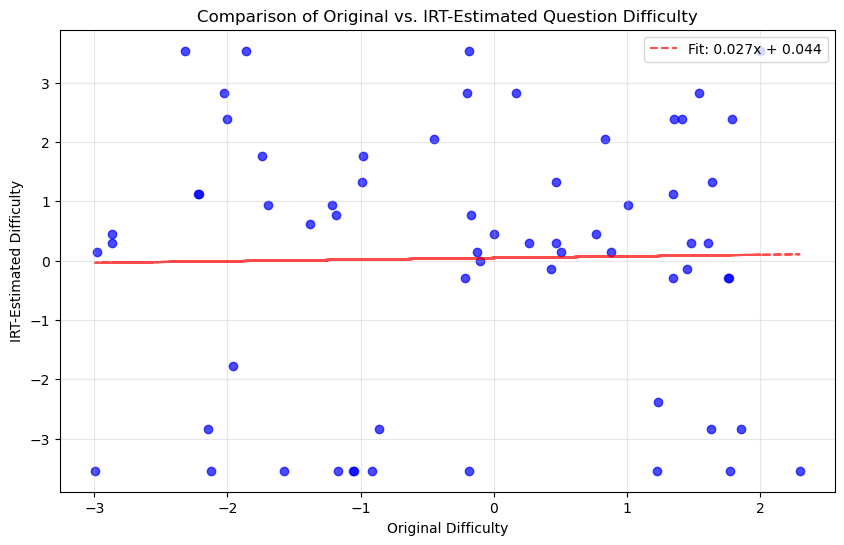

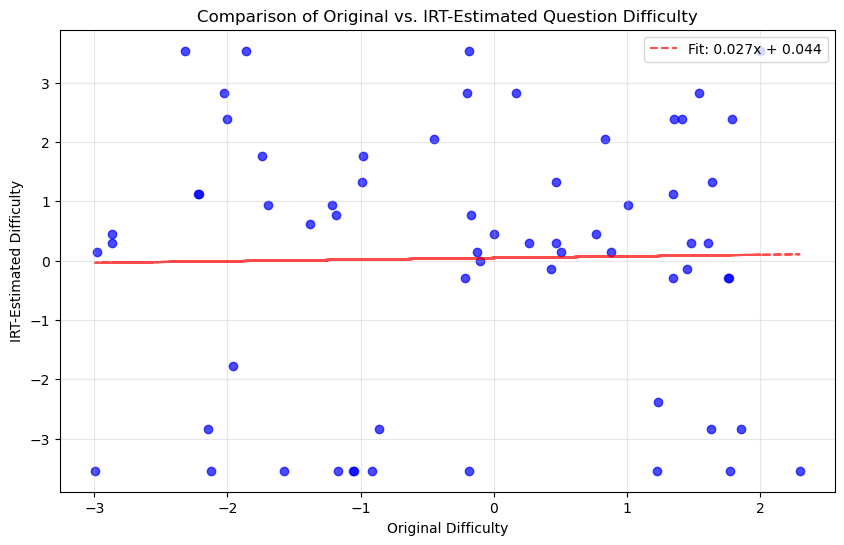

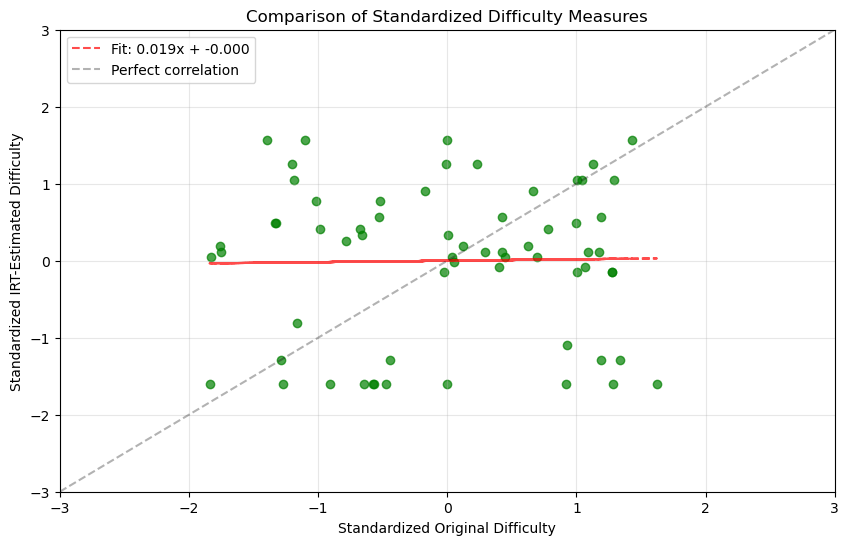

In [8]:
# Example usage:
comparison_df = compare_difficulty_values(question_difficulties, selected_questions)
standardized_comparison = standardize_and_compare(question_difficulties, selected_questions)

# To save the comparison results:
comparison_df.to_csv("difficulty_comparison_subgroup.csv", index=False)

## Next Steps
1. **Performance Analysis**: Check the distribution of F1 scores across the 50 user models. Evaluate if there's a strong correlation between the number of training samples a user has and the final model performance.
2. **Generalization**: Consider how well these models will generalize to new questions or topics not seen in the training set.
3. **Difficulty Estimation**: If these models accurately simulate student responses, use them to compute question difficulty by querying each synthetic student.
4. **Integration with Real Students**: Compare synthetic responses with real student performance to validate the realism of the simulated data.

This completes the core demonstration of training separate ModernBERT models per user.

In [ ]:
# Filter df_original for question_id 20540
filtered_df = df_original[df_original['question_id'] == 22927]

# Select only the requested columns
result = filtered_df[['answer_id', 'question_id', 'difficulty']]

print("All results:")
print(result.to_string())




In [ ]:
# Load the original difficulties from selected_questions
original_difficulties = selected_questions['difficulty'].values

# Load the IRT-generated difficulties
irt_difficulties = pd.read_csv('question_parameters.csv')['difficulty'].values

# Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'question_id': selected_questions.index,
    'original_difficulty': original_difficulties,
    'irt_difficulty': irt_difficulties
})

# Calculate correlation
correlation = np.corrcoef(original_difficulties, irt_difficulties)[0,1]

print("Correlation between original and IRT difficulties:", correlation)

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(original_difficulties, irt_difficulties, alpha=0.6)
plt.plot([-3, 3], [-3, 3], 'r--', alpha=0.5)  # diagonal line for reference
plt.xlabel('Original Difficulty')
plt.ylabel('IRT-Estimated Difficulty')
plt.title('Comparison of Original vs IRT-Estimated Difficulties')
plt.grid(True, alpha=0.3)

# Add correlation coefficient to plot
plt.text(0.05, 0.95, f'Correlation: {correlation:.2f}', 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.show()

# Print detailed comparison
print("\nDetailed Comparison (sorted by absolute difference):")
comparison_df['diff'] = abs(comparison_df['original_difficulty'] - comparison_df['irt_difficulty'])
print(comparison_df.sort_values('diff', ascending=False))